# Signal Processing Applied to Neuroscience
*Tutorial Prepared by Taylor Baum for the 2022 Quantitative Methods Workshop*

In this tutorial, we will explore signals from the brain known as steady state visually evoked potentials (SSVEP).

The goal of this workshop is to do the following:
* Familiarize you with a commonly used non-invasive brain signal acquisition device called an Electroencephologram (EEG).
* Familiarize you with a signal commonly used in brain computer interfaces, Steady State Visually Evoked Potentials (SSVEP).
* Get an abstract understanding of Signal Processing and Frequency Analysis.
  * Understand the application and usefulness of these techniques in analyzing EEG signals.
  * Move through the process of implementing these techniques in Python3.

## Prework

In the prework, you should get familiar with the data set that we will be using. The paper attached is the paper that was published alone with the open source data set that we will be using. 

Please complete the following tasks for Jan 5, 2022:
1. Read [this](https://drive.google.com/file/d/1_vCOCao3aY8dHFO9fb45-HXVxxu6nN-R/view?usp=sharing) to understand where the data we are using comes from.
2. Watch [this](https://www.youtube.com/watch?v=t96rl1SFHlI) to get a better understanding of what an SSVEP signal is.

## Let's Code

First, let's install and load all of the packages we will be using for this tutorial. This includes downloading a github repository we will be getting our data from.

In [ ]:
# Make Sure Packages are Installed
!pip3 install pandas
!pip3 install matplotlib
!pip3 install numpy
!pip3 install scipy
!pip3 install seaborn

# Import Packages
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy import signal
import os
import scipy.io
import seaborn as sns
import cmath

# Set Plotting Presets
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['text.usetex'] = False
plt.rcParams.update({'font.size': 14})

In [ ]:
# Remove any existing folder
!rm -rf SSVEP-Tutorial/

In [ ]:
# Upload Repository to Google Directory
%%bash
git clone https://github.com/teb5240/SSVEP-Tutorial.git

Cloning into 'SSVEP-Tutorial'...
Checking out files: 100% (121/121), done.


## Understand Our Data

First, given the data set that we have downloaded, we want to upload it to our notebook. The above cell has mounted a github repository to this notebook, and now we must download the data! The data is contained in the SSVEP-Tutorial/data/Patients folder.

First, let's review some information from the README of the data set. The most important information is the following:

* The dataset is about 928 MB from 102 subjects.
* The sample rate is 1000 Hz and all data are downsampled to 250 Hz from raw data without any other processing.
* For each file, a 5-dimensional matrix named “data” with dimensions of [8, 710, 2, 10, 12].
  * The five dimensions indicate: 
    0. “Channel index”
    1. “Time points”
    2. “Electrode index” (0:dry, 1:wet)
    3. “Block index”
    4. “Target index”
  * The channel index indicates
    0. POz
    1. PO3
    2. PO4
    3. PO5
    4. PO6
    5. Oz
    6. O1
    7. O2 
  * The target index indicates:
    0. Target: 1  at Frequency: 9.25 Hz
    1. Target: 2  at Frequency: 11.25 Hz
    2. Target: 3  at Frequency: 13.25 Hz
    3. Target: 4  at Frequency: 9.75 Hz 
    4. Target: 5  at Frequency: 11.75 Hz 
    5. Target: 6  at Frequency: 13.75 Hz 
    6. Target: 7  at Frequency: 10.25 Hz 
    7. Target: 8  at Frequency: 12.25 Hz 
    8. Target: 9  at Frequency: 14.25 Hz
    9. Target: 0  at Frequency: 10.75 Hz 
    10. Target: *  at Frequency: 12.75 Hz
    11. Target: #  at Frequency: 14.75 Hz
* In terms of single subject, the data matrix consists of 240 trials (12 targets × 10 blocks × 2 electrodes)
and each trial consists of 8 channels of 710 points of data. 
* The data length of 2.84 seconds (i.e. 2.84 seconds × 250 Hz = 710 time points) include 
  * 0.5 s before stimulus onset
  * 2 s for stimulation
  * 0.14 s visual latency
  * 0.2 s after stimulus offset. 
* To keep all original information, the data epochs were directly extracted from the raw continuous data without any processing.



### Exercise: Isolate A Single EEG Signal

Now, given we have a better understanding of our data, let's load it into the system! 

Tasks:
1. Select a Patient
2. Isolate the EEG Signals for that patient from Channel PO5, with Wet Electrodes, and a Target of 1.

In [ ]:
# Navigate to Patient Data
data_path = '/content/SSVEP-Tutorial/data/Patients'
os.chdir(data_path)

# Get All Patient File Names
patients = os.listdir()

# Select a Patient Between 0 and 101
patient = patients[10]

# Extract Data from Files
data_temp = scipy.io.loadmat(patient)
eeg_data = data_temp['data']
patient_data[patient.replace('.mat', '')] = eeg_data

# Choose What we Want
channel_index = 3
electrode_index = 1
target_index = 0

# Isolate the Data    
isolated_eeg = np.array(eeg_data[channel_index, :, electrode_index, :, target_index])

## Time Domain Representation

The major concept that we will be focusing on today is a huge topic in signal processing known as **frequency analysis**. Frequency analysis is a field with which we convert a signal from the **time domain** into the **frequency domain**. 

The time domain very abstractly refers to when a signal is represented on a plot where there is some value changing over time. In EEG land, this is voltage over time for some electrode location on the scalp.

Let's do this with our data!

### Exercise: Plot A Time-Domain Signal of One EEG Channel

Now, let's further isolate a single signal and then plot it.

Tasks:
1. Select a single EEG signal
2. Create a Time Vector
3. Plot the Signal

In [ ]:
# Explore the Data
print("Shape of Full EEG Data Matrix: " + str(eeg_data.shape))
print("Shape of Isolated EEG Matrix: " + str(isolated_eeg.shape))

# Choose a Single Signal to Look At
signal_index = 2 # Limited by the number of signals you have!
eeg_signal = isolated_eeg[:, signal_index] # Extract signal

Shape of Full EEG Data Matrix: (8, 710, 2, 10, 12)
Shape of Isolated EEG Matrix: (710, 10)


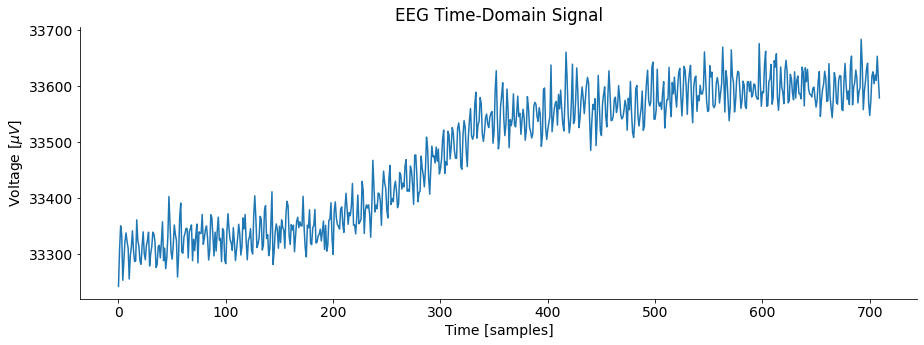

In [ ]:
# Plot the Signal in Samples
plt.figure()
plt.plot(eeg_signal)
plt.title('EEG Time-Domain Signal')
plt.xlabel('Time [samples]')
plt.ylabel(r'Voltage [$\mu V$]')
sns.despine()

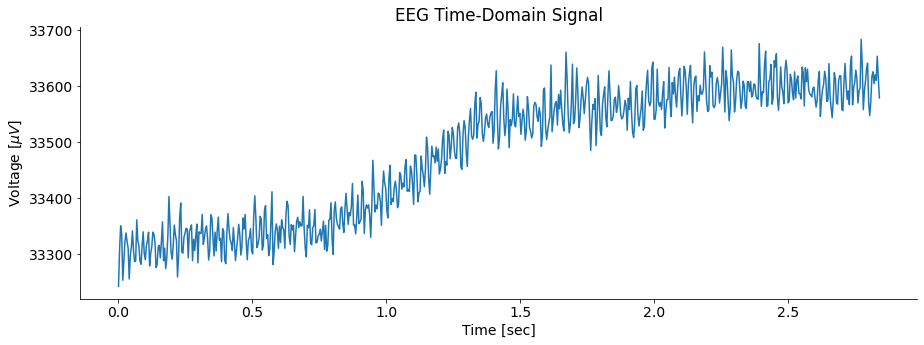

In [ ]:
# Generate a Time Vector in Seconds
time = np.linspace(0, 2.84, isolated_eeg.shape[0])

# Plot the Signal in Seconds
plt.figure()
plt.plot(time, eeg_signal)
plt.title('EEG Time-Domain Signal')
plt.xlabel('Time [sec]')
plt.ylabel(r'Voltage [$\mu V$]')
sns.despine()

## Frequency Domain Representation

Now, let’s start to think about representing the signal shown below here in the **frequency domain**! 

The most often used method for frequency transformation  is known as the Fourier Transform. With this equation, we turn a time domain signal into a frequency domain signal. See below how the left side of the equation has a function of frequency, $X(j\Omega)$, where the right side, $x(t)$ is a function of time. 

\begin{equation}
    X(j\Omega) = \int_{-\infty}^{\infty}x(t) e^{-j\Omega t} dt
\end{equation}

Well, using the fourier transform, we are basically saying that a random looking signal is made of a composition of sine waves at a certain frequency!

Frequency, $\Omega$, refers to how often something happens (something happening some number of times per some unit of time). For example, this could be something like number of jumps per second (jumps/sec). Understanding what frequency refers to is good, but how can we turn a signal in the time domain into a signal in the frequency domain, and what does that even mean?

To represent a signal in the frequency domain rather than the time domain, the x-axis is no longer time; it becomes frequency. Let's get some practice with implementing a frequency transformation on our signal.




### Exercise: Calculate the Frequency Domain Representation of the Signal of Which You Plotted the Time Domain Representation.

Here, you are provided you with a function which takes in a signal, and its sampling rate, takes the frequency transformation with something called an FFT (it's kinda a fourier transform), and then plots the signal.

Tasks:
1. Call the function with the eeg signal you plotted the time domain of above.
2. Try an interpret the plots generated and what you think they mean.
3. [Optional] Comment each line in the function to identify how the function works. Look at documentation for the functions used from different packages to help.

In [ ]:
def calculate_plot_frequency_domain(signal, fs = 1):
    """ This function takes in a discrete time signal, and then plots its 
    frequency domain representation using the FFT.

    Input Arguments:
      signal = discrete time domain signal sampled at the fs sampling rate [V]
      fs = sampling rate [Hz]

    Outputs:
      A plot of the frequency domain representation

    Returns:

    Taylor Baum 2022, Quantitative Methods Workshop
    """
      
    fft_output = np.fft.fft(signal) # FFT of Input Samples
    N = len(fft_output) # Number of samples of the DTFT for the DFT
    
    amplitude = np.absolute(fft_output) # calculate the amplitude
    phase = np.angle(fft_output) # calculate the phase
    
    frequencies = np.linspace(0, fs, 710)
    print(N/2)
    half_frequencies = frequencies[0:int(N/2)]
    half_amplitude = amplitude[0:int(N/2)]
    half_phase = phase[0:int(N/2)]
    
    fig, axs = plt.subplots(2) 
    axs[0].set_title('Frequency Representation')
    axs[0].plot(half_frequencies, half_amplitude) # plot amplitude
    axs[0].set_yscale('log')
    axs[0].set_ylabel(r'Voltage [$\mu V$]')
    axs[1].plot(half_frequencies, half_phase) # plot phase
    axs[1].set_xlabel('Frequency [Hz]')
    axs[1].set_ylabel(r'Phase [rad]')
    sns.despine()
    plt.show()

help(calculate_plot_frequency_domain)

Help on function calculate_plot_frequency_domain in module __main__:

calculate_plot_frequency_domain(signal, fs=1)
    This function takes in a discrete time signal, and then plots its 
    frequency domain representation using the FFT.
    
    Input Arguments:
      signal = discrete time domain signal sampled at the fs sampling rate [V]
      fs = sampling rate [Hz]
    
    Outputs:
      A plot of the frequency domain representation
    
    Returns:
    
    Taylor Baum 2022, Quantitative Methods Workshop



355.0


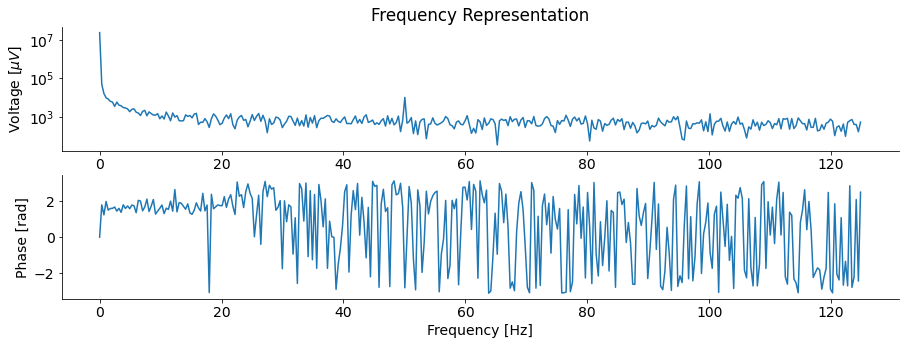

In [ ]:
# Plot the Signal in The Frequency Domain
fs = 250
calculate_plot_frequency_domain(eeg_signal, fs)

## Filters

One thing you may have noticed in the frequency domain of our signal is that it isn’t centered around zero. This isn’t helpful to us understanding the signal, so we want to “fix this.” In signal processing land, “fixing this” means to extract better information from the signal outside of stuff we don’t want.

Now, in order to get rid of frequencies that we don’t like, we will use something called a filter. To use a filter, you basically take the frequency domain of the signal and multiply it by the frequency domain of the filter.

So a low pass filter, for instance, will zero all of the higher frequency components. A high pass filter will zero all of the lower  frequency components.

So, we will be using a filter to get rid of the fact that the signal is shifted upwards.

### Exercise: Build a bandpass filter to remove the DC component of the signal (the part that shifts the signal up).

Here, you are provided you with a function which takes in a signal, its sampling rate, and two arrays indicating aspects of the desing of the filter. This function takes in a discrete time signal, calculates a discrete time bandpass filter, visualizes the filter, and then filters the signal.

Tasks:
1. Call the function with the eeg signal you plotted the frequency domain of above.
2. Choose arrays that you think make sense for your filter pass and stop bands.
3. Try an interpret the plots generated and what you think they mean.
4. [Optional] Comment each line in the function to identify how the function works. Look at documentation for the functions used from different packages to help.

In [ ]:
def bandpass_chebII(signal_to_filter, Omega_pass, Omega_stop, fs):
    """ This function takes in a discrete time signal, calculates a discrete
    time bandpass filter, visualizes the filter, and then filters the signal.

    Input Arguments:
      signal_to_filter = discrete time domain signal sampled at the fs 
                         sampling rate [V]
      fs = sampling rate of the discrete time signal to be filtered [Hz]
      Omega_pass = Array of frequencies indicating where, inside of the 
                   bounds is the passband of the filter[Hz]
      Omega_stop = Array of frequencies indicating where, outside of the 
                   bounds is the stopband of the filter [Hz]

    Outputs:
      A plot of the frequency domain representation of the filter

    Returns:
      filtered_signal = filtered signal, output of the original signal filtered 
                        by the calculated filter

    Taylor Baum 2022, Quantitative Methods Workshop
    """

    print(" -------------------- BUILDING BANDPASS FILTER WITH CHEB II WINDOW -------------------- ")

    # Initialize IIR Parameters
    omega_pass     = (2 * Omega_pass) / fs # normalized band
    omega_stop     = (2 * Omega_stop) / fs # normalized band
    max_gain_pass  = 0 # dB
    min_atten_pass = 1 # dB
    ripple_pass    = min_atten_pass - max_gain_pass # dB
    max_atten_stop = 50 # dB

    # Generate Filter Parameters
    ord, ws = signal.cheb2ord(omega_pass, omega_stop, min_atten_pass - max_gain_pass, max_atten_stop)

    # Outputs polynomial coefficients, using the bilinear transform automatically
    b, a = signal.cheby2(ord, max_atten_stop, ws, btype='band',  output='ba')
    
    # Plot Frequency Response with b, a Coefficients
    frequencies, filter_frequency_response = signal.freqz(b, a)
    frequencies_cont = frequencies * fs / (2 * np.pi)
    amplitude = np.abs(filter_frequency_response)
    phase = np.angle(filter_frequency_response)
    
    # Format Plot
    fig, axs = plt.subplots(2) 
    axs[0].set_title('Bandpass Filter Frequency Representation')
    axs[0].plot(frequencies_cont, 20 * np.log10(amplitude)) # plot amplitude
    axs[0].set_ylabel(r'Power [dB]')
    axs[1].plot(frequencies_cont, phase) # plot phase
    axs[1].set_xlabel('Frequency [Hz]')
    axs[1].set_ylabel(r'Phase [rad]')
    sns.despine()
    
    # Filter Signal
    filtered_signal = signal.filtfilt(b, a, signal_to_filter)

    return filtered_signal

help(bandpass_chebII)

Help on function bandpass_chebII in module __main__:

bandpass_chebII(signal_to_filter, Omega_pass, Omega_stop, fs)
    This function takes in a discrete time signal, calculates a discrete
    time bandpass filter, visualizes the filter, and then filters the signal.
    
    Input Arguments:
      signal_to_filter = discrete time domain signal sampled at the fs 
                         sampling rate [V]
      fs = sampling rate of the discrete time signal to be filtered [Hz]
      Omega_pass = Array of frequencies indicating where, inside of the 
                   bounds is the passband of the filter[Hz]
      Omega_stop = Array of frequencies indicating where, outside of the 
                   bounds is the stopband of the filter [Hz]
    
    Outputs:
      A plot of the frequency domain representation of the filter
    
    Returns:
      filtered_signal = filtered signal, output of the original signal filtered 
                        by the calculated filter
    
    Taylor Bau

 -------------------- BUILDING BANDPASS FILTER WITH CHEB II WINDOW -------------------- 


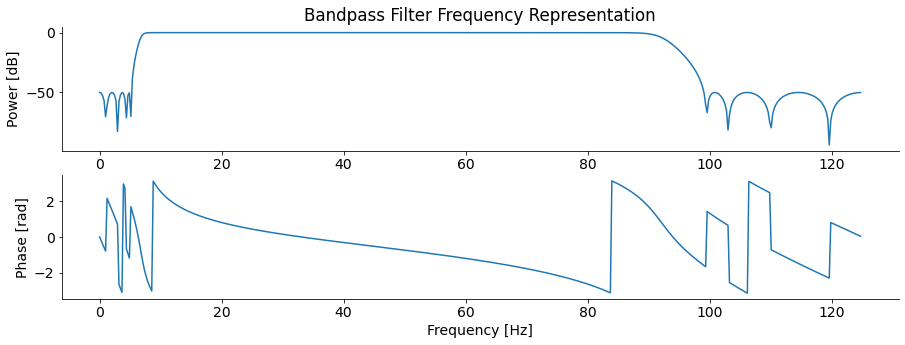

In [ ]:
# Choose the Bandpass Filter Values
Omega_pass = np.array([7.25, 90])  # Pass Band of Band Pass Filter in [Hz]
Omega_stop = np.array([4, 100])  # Stop Band of Band Pass Filter in [Hz]
filtered_eeg_signal = bandpass_chebII(eeg_signal, Omega_pass, Omega_stop, fs)

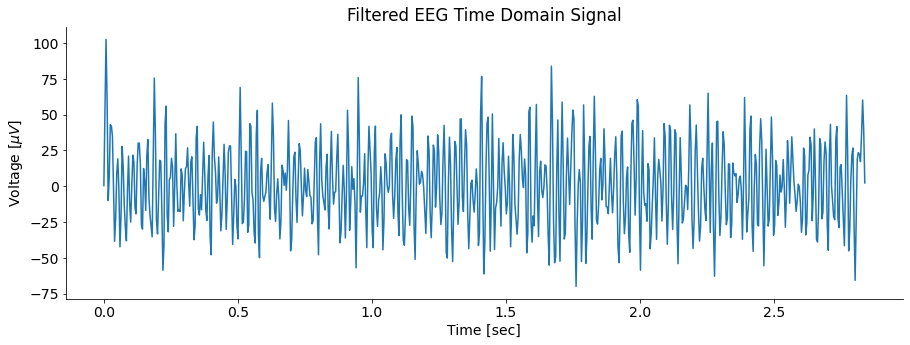

In [ ]:
# Plot the Signal in Seconds
plt.figure()
plt.plot(time, filtered_eeg_signal)
plt.title('Filtered EEG Time Domain Signal')
plt.xlabel('Time [sec]')
plt.ylabel(r'Voltage [$\mu V$]')
sns.despine()

355.0


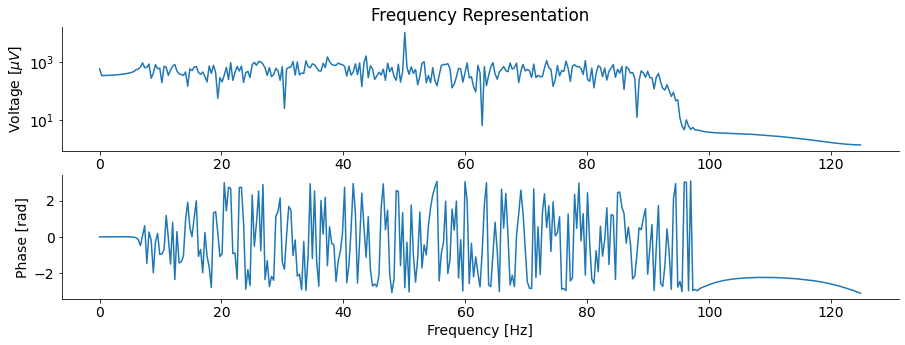

In [ ]:
# Plot Frequency Domain
calculate_plot_frequency_domain(filtered_eeg_signal, fs)

## Filters for Feature Extraction

Now, let's use filters to help us identify features in our EEG signal that are important to us!

Given the paper that we have read, why would filters be helpful?

Well, we will want to isolate different frequencies in the signal. SSVEPs are frequencies present in an EEG signal from visual stimuli.

### Exercise: Build a bandpass filter to isolate some frequency band.


Let's build a bandpass filter that tries to isolate the frequencies we care about!

Tasks:
1. Call the function with the eeg signal you plotted the frequency domain of above.
2. Choose arrays that you think make sense for your filter pass and stop bands.
3. Try and interpret the plots generated and what you think they mean.

 -------------------- BUILDING BANDPASS FILTER WITH CHEB II WINDOW -------------------- 


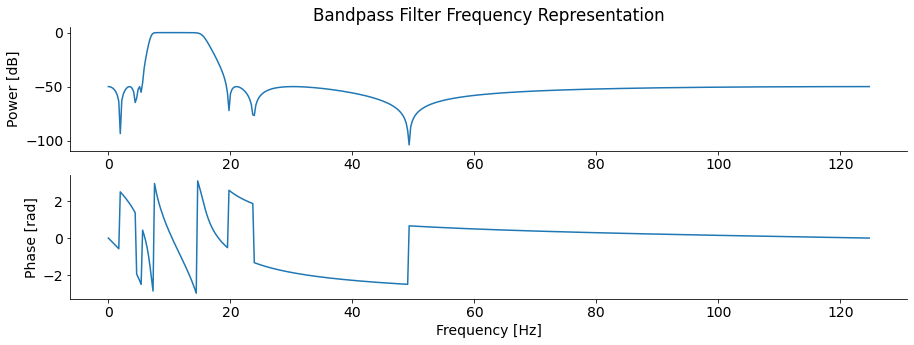

In [ ]:
# Build A Filter to Extract Relevant Frequencies
Omega_pass = np.array([7.25, 15])  # Pass Band of Band Pass Filter in [Hz]
Omega_stop = np.array([4, 20])  # Stop Band of Band Pass Filter in [Hz]
filtered_eeg_signal = bandpass_chebII(eeg_signal, Omega_pass, Omega_stop, fs)

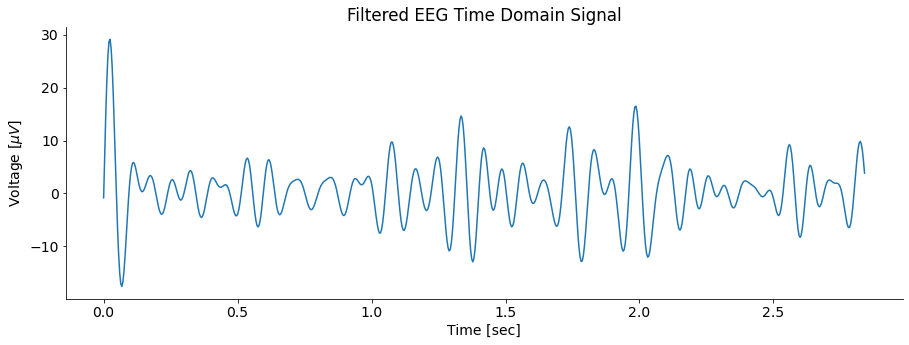

In [ ]:
# Plot the Signal in Seconds
plt.figure()
plt.plot(time, filtered_eeg_signal)
plt.title('Filtered EEG Time Domain Signal')
plt.xlabel('Time [sec]')
plt.ylabel(r'Voltage [$\mu V$]')
sns.despine()

355.0


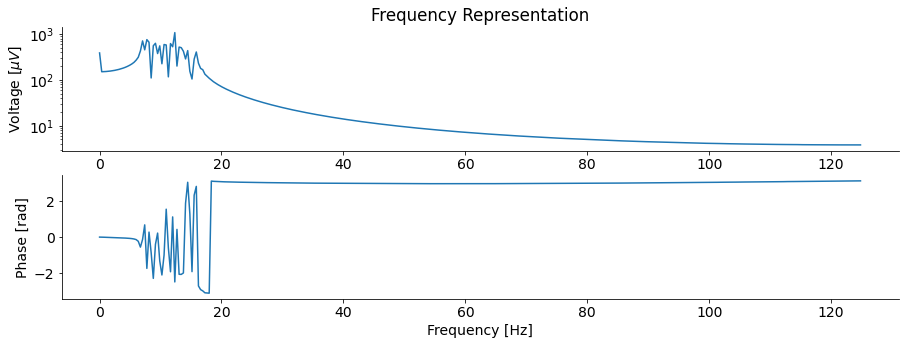

In [ ]:
# Plot Frequency Domain
calculate_plot_frequency_domain(filtered_eeg_signal, fs)

## Generate Figure 4

Now, we have moved through the process of plotting an EEG signal in the time domain, 

### Download the Data and Extract all Oz Electrode Data

First, we provide you with a matrix, Oz. Oz is a matrix of size 710 by number of EEGs. With this matrix, we want to average all of the EEGs. We provide you with this code as it may be useful in the future to download data from a folder!

In [ ]:
# Navigate to Patient Data
data_path = '/content/SSVEP-Tutorial/data/Patients'
os.chdir(data_path)

# Get All Patient File Names
patients = os.listdir()

# Initialize a Dictionary
patient_data = {}

# Isolate all the data for 11.25 Hz (Index 1)
for index, patient in enumerate(patients):
    
    data_temp = scipy.io.loadmat(patient)
    eeg_data = data_temp['data']
    patient_data[patient.replace('.mat', '')] = eeg_data
    
    if index == 0:
        
        Oz_patient = eeg_data[5, :, 1, :, 1]
        Oz = np.array(Oz_patient)
        
    else:
        
        Oz_patient = eeg_data[5, :, 1, :, 1]
        Oz = np.append(Oz, Oz_patient, axis = 1)
        
# Load Subject Information
os.chdir('..')
subjects = scipy.io.loadmat('Subjects_Information.mat')

# Look at Oz
print('Shape of Oz Matrix: ' + str(Oz.shape))

Shape of Oz Matrix: (710, 600)


### Exercise: Average Oz Electrode Data For All Patients and All Blocks

First, following what the authors did in Zhu 2021, let's average all of the Oz signals for all of the patients.

Tasks:
1. Average the `Oz` matrix to get the average time domain signal
2. Plot the average Oz time domain signal
3. Plot the frequency domain

In [ ]:
# Average the Data for Every Patient, and Every Block
Oz_average = np.average(Oz, axis = 1)

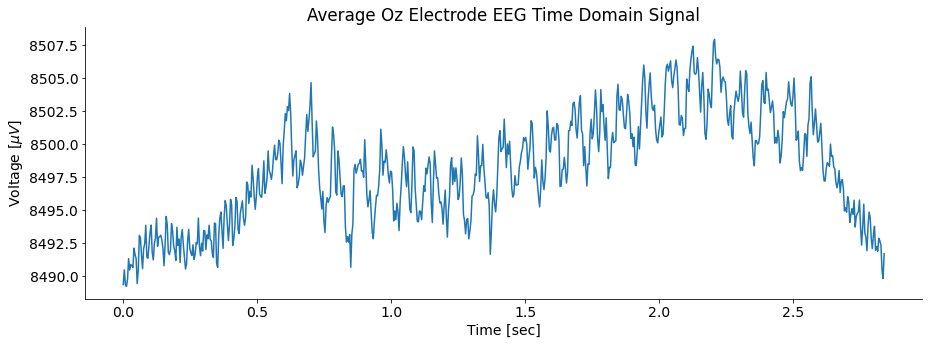

In [ ]:
# Plot the Signal in Seconds
plt.figure()
plt.plot(time, Oz_average)
plt.title('Average Oz Electrode EEG Time Domain Signal')
plt.xlabel('Time [sec]')
plt.ylabel(r'Voltage [$\mu V$]')
sns.despine()

355.0


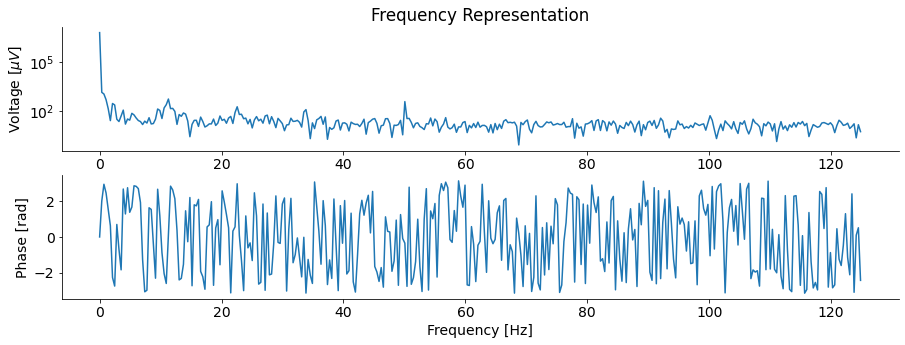

In [ ]:
# Plot Frequency Domain
calculate_plot_frequency_domain(Oz_average, fs)

### Exercise: Bandpass the Signal to Isolate 7.25 Hz to 90 Hz the Plot the Time Domain.

Next, following what the authors did in Zhu 2021, let's build a bandpass filter like they did! They passed frequencies from 7.25 to 90!

Tasks:
1. Choose Omega_pass and Omega_stop to build a filter like was built in the paper.
2. Call the filter function on the Oz averaged data.
3. Look at the Frequency Representation

 -------------------- BUILDING BANDPASS FILTER WITH CHEB II WINDOW -------------------- 


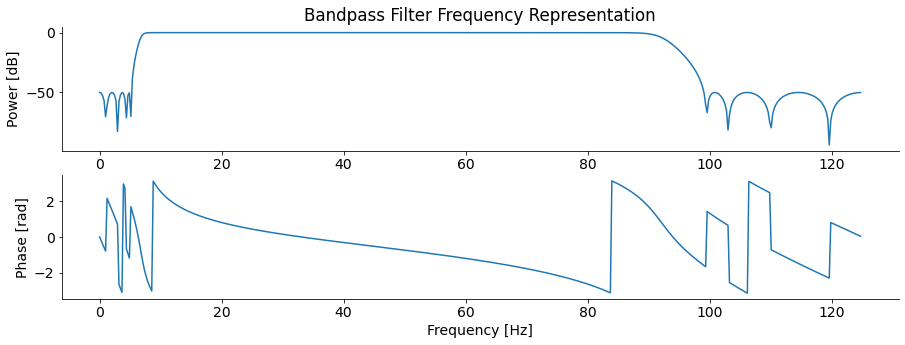

In [ ]:
# Build the Filter
Omega_pass = np.array([7.25, 90])  # Pass Band of Band Pass Filter in [Hz]
Omega_stop = np.array([4, 100])  # Stop Band of Band Pass Filter in [Hz]
filtered_Oz_average = bandpass_chebII(Oz_average, Omega_pass, Omega_stop, fs)

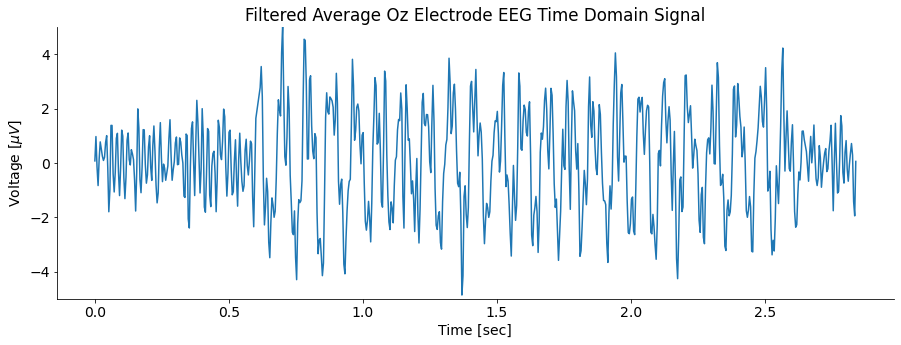

In [ ]:
# Plot the Signal in Seconds
plt.figure()
plt.plot(time, filtered_Oz_average)
plt.title('Filtered Average Oz Electrode EEG Time Domain Signal')
plt.xlabel('Time [sec]')
plt.ylabel(r'Voltage [$\mu V$]')
plt.ylim([-5, 5])
sns.despine()

355.0


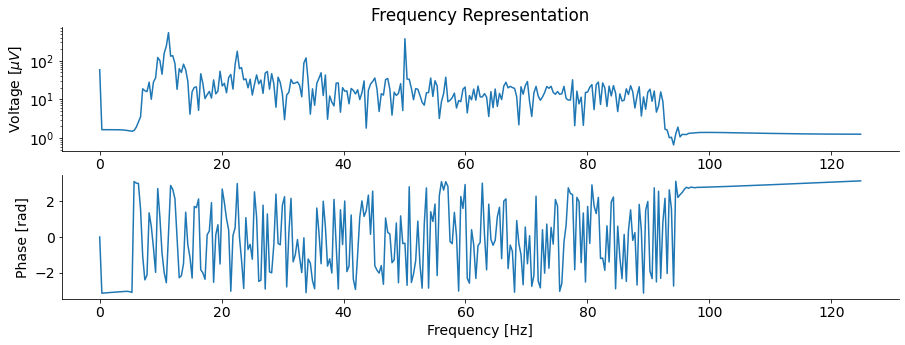

In [ ]:
# Plot Frequency Domain
calculate_plot_frequency_domain(filtered_Oz_average, fs)

### Exercise: Bandpass the Signal to Extract 11.25 Hz and Plot the Time Domain.

Now, let's go a little further and try to isolate 11.25 Hz with a bandpass filter. 

Tasks:
1. Choose Omega_pass and Omega_stop to build a filter to more clearly extract 11.25 Hz
2. Call the filter function on the Oz averaged data.
3. Look at the Time Domain Representation
3. Look at the Frequency Domain Representation

 -------------------- BUILDING BANDPASS FILTER WITH CHEB II WINDOW -------------------- 


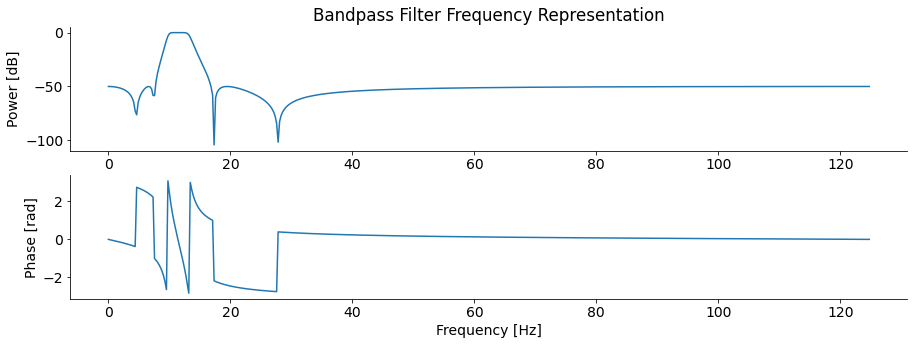

In [ ]:
Omega_pass = np.array([10, 13])  # Pass Band of Band Pass Filter in [Hz]
Omega_stop = np.array([4, 17])  # Stop Band of Band Pass Filter in [Hz]
filtered_Oz_average = bandpass_chebII(Oz_average, Omega_pass, Omega_stop, fs)

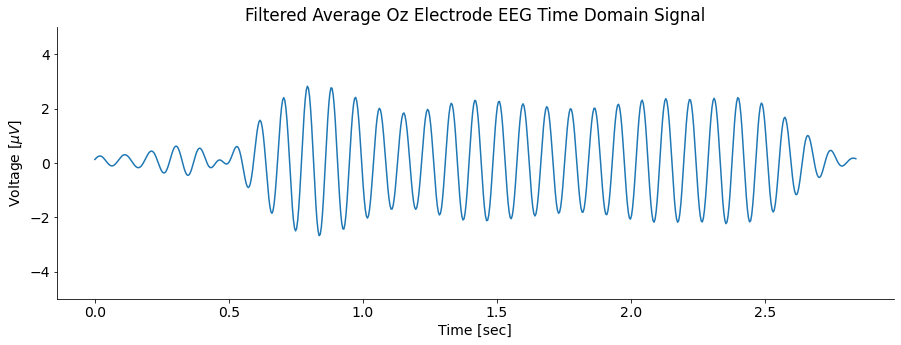

In [ ]:
# Plot the Signal in Seconds
plt.figure()
plt.plot(time, filtered_Oz_average)
plt.title('Filtered Average Oz Electrode EEG Time Domain Signal')
plt.xlabel('Time [sec]')
plt.ylabel(r'Voltage [$\mu V$]')
plt.ylim([-5, 5])
sns.despine()

355.0


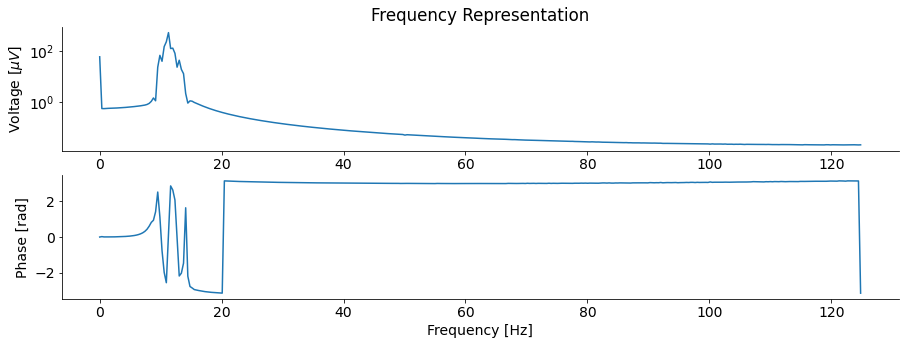

In [ ]:
# Plot Frequency Domain
calculate_plot_frequency_domain(filtered_Oz_average, fs)

### Exercise: Bandpass the Signal to Extract a different Band and Plot the Time Domain.

Now, try to isolate a different frequency away from 11.25 Hz with a bandpass filter. 

Tasks:
1. Choose Omega_pass and Omega_stop to build a filter to more clearly extract a frequency other than 11.25
2. Call the filter function on the Oz averaged data.
3. Look at the Time Domain Representation
3. Look at the Frequency Domain Representation
4. Compare the Two Outputs and Assess Your Understanding of the Difference and if the Difference Makes Sense

 -------------------- BUILDING BANDPASS FILTER WITH CHEB II WINDOW -------------------- 


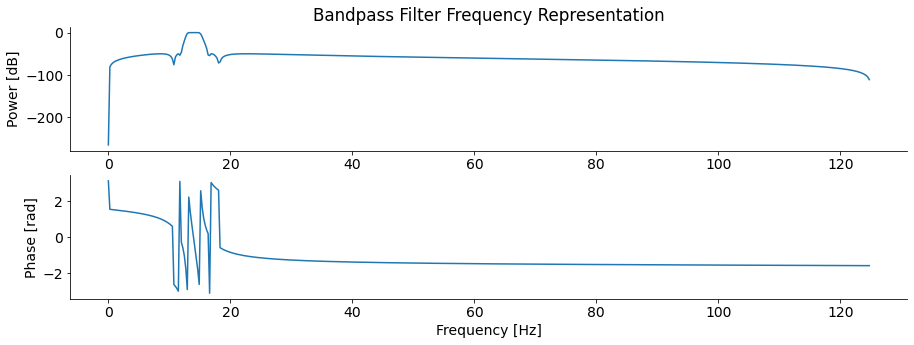

In [ ]:
Omega_pass = np.array([13, 15])  # Pass Band of Band Pass Filter in [Hz]
Omega_stop = np.array([10, 17])  # Stop Band of Band Pass Filter in [Hz]
filtered_Oz_average = bandpass_chebII(Oz_average, Omega_pass, Omega_stop, fs)

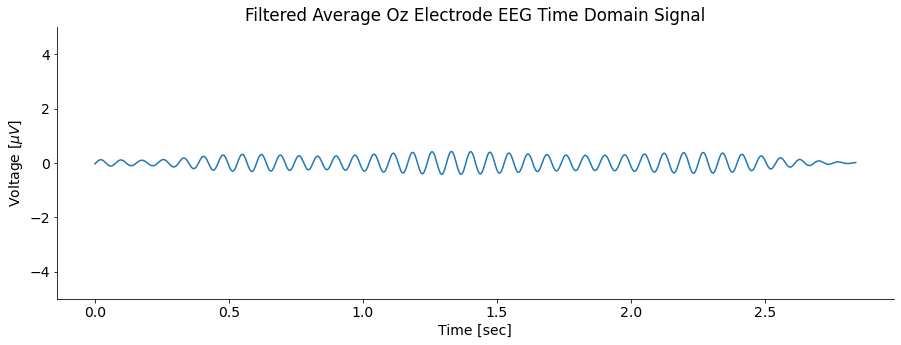

In [ ]:
# Plot the Signal in Seconds
plt.figure()
plt.plot(time, filtered_Oz_average)
plt.title('Filtered Average Oz Electrode EEG Time Domain Signal')
plt.xlabel('Time [sec]')
plt.ylabel(r'Voltage [$\mu V$]')
plt.ylim([-5, 5])
sns.despine()

355.0


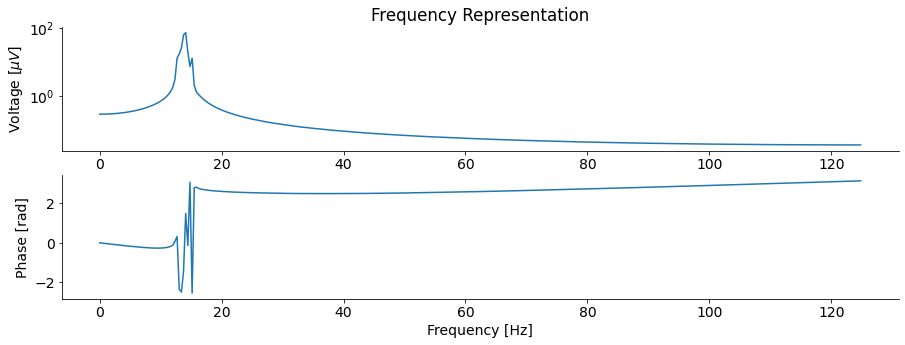

In [ ]:
# Plot Frequency Domain
calculate_plot_frequency_domain(filtered_Oz_average, fs)